### Import Packages

In [1]:
import pandas as pd
import logging 
import os
import time
import requests 
import tiktoken
import ray
import numpy as np
import json
import pickle
import openai

from math import ceil
from numba import jit
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# In order for ray to work, make sure you uninstall pydantic and reinstall this: pip install "pydantic<2"
from class_data.data import Data
from utils.system import *

# Set OPENAI KEY
os.environ["OPENAI_API_KEY"] = json.load(open(get_config() / 'api.json'))['openai_api_key']

import warnings
warnings.filterwarnings('ignore')

### CC

In [2]:
# Daily Multiple CC Metadata
mdata = Data(folder_path=get_data() / 'cc_multiple', file_pattern='*_mdata.pq')
mdata = mdata.concat_files()
mdata['date'] = pd.to_datetime(mdata['startDate'], format='%d-%b-%y %I:%M%p %Z')
mdata['date'] = mdata['date'].dt.date
mdata['date'] = pd.to_datetime(mdata['date'])
print(mdata.shape)

Loading Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:01<00:00, 408.90it/s]


(438179, 8)


In [3]:
# Daily Multiple CC Articles
contents = Data(folder_path=get_data() / 'cc_multiple', file_pattern='*_contents.pq')
contents = contents.concat_files()
print(contents.shape)

Loading Data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [00:29<00:00, 14.68it/s]


(28022815, 4)


In [4]:
# Filter mdata for sp500
def get_candidate():
    with open(get_data() / 'sp500_candidates.pkl', 'rb') as f:
        candidates = pickle.load(f)
    beginning_year = [date for date in candidates.keys() if date.month == 1]
    candidates = {date.year: candidates[date] for date in beginning_year if date in candidates}
    return candidates

# Get unique sp500 tickers
sp500_all = get_candidate()
sp500 = set()
for year, tickers in sp500_all.items():
    if year < 2000:
        continue
    sp500.update(tickers)
sp500 = list(sp500)

mdata_sp500 = mdata.loc[mdata.companyTicker.isin(sp500)]
len(mdata_sp500.companyTicker.unique())

660

In [5]:
# Join contents and mdata
mdata_sp500 = mdata_sp500.set_index('fid')
contents = contents.set_index('fid')
contents_all = mdata_sp500.join(contents)

In [6]:
# Set index
contents_all = contents_all.reset_index().set_index(['fid', 'date'])
contents_all.shape

(5861667, 9)

In [7]:
# Filter for conference calls
cc_substrings = ['corporate conference call', 'earnings call', 'earnings conference call', 'conference call']
contents_all['cc_or_not'] = contents_all['Headline'].str.lower().str.contains('|'.join(cc_substrings))
cc = contents_all.loc[contents_all['cc_or_not'] == True]
cc.shape

(4449978, 10)

In [8]:
# Get word count
@jit
def fast_word_count(texts):
    counts = np.zeros(len(texts), dtype=np.int32)
    for i, text in enumerate(texts):
        if isinstance(text, str):  
            counts[i] = len(text.split())
        else:
            counts[i] = 0  
    return counts

cc['word_count'] = fast_word_count(cc['body'].values)

In [9]:
# Filter for text with >= word_count words
word_count = 80
cc = cc.loc[cc.word_count >= 80]
cc.shape

(1197859, 11)

In [10]:
# # Filter for only QA
# cc = cc.loc[cc.content_type == 'QA']
# cc.shape

(1002378, 11)

In [10]:
# Truncate text to 4000 words
def truncate_text(text, max_words=4000):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

cc['body'] = cc['body'].apply(truncate_text)
cc['word_count'] = fast_word_count(cc['body'].values)

word count mean: 263.6037346632617
word count std: 397.7505465636234
word count max: 4000


<Axes: >

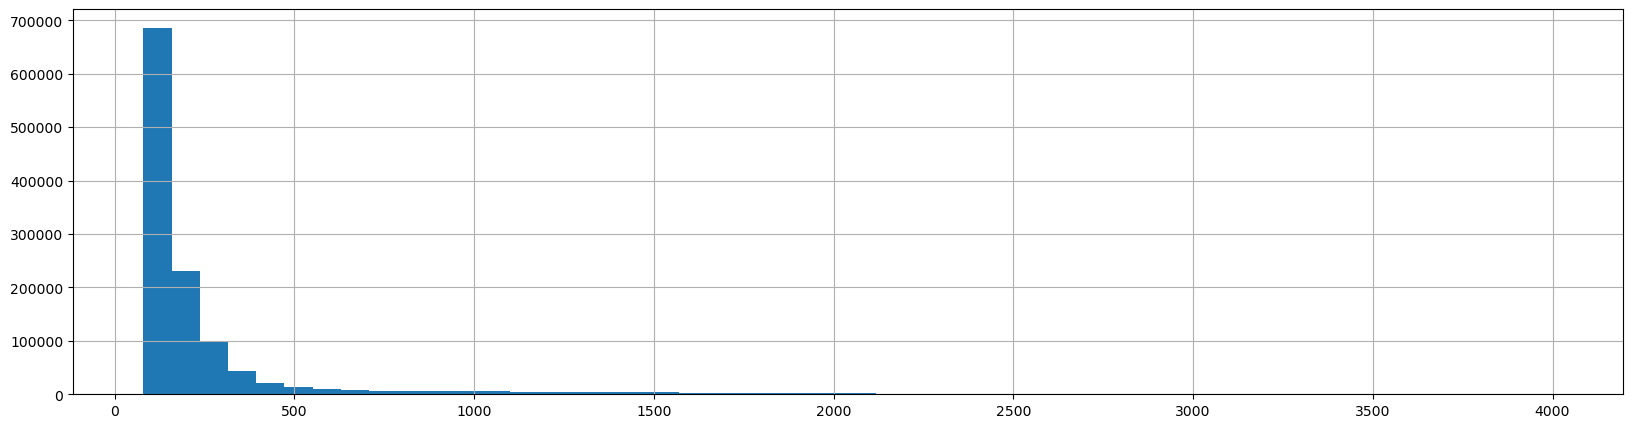

In [11]:
# Display Metrics
print("word count mean:", cc.word_count.mean())
print("word count std:", cc.word_count.std())
print("word count max:", cc.word_count.max())
cc.word_count.hist(bins=50, figsize=(20,5))

In [12]:
# Rename column 'body' to 'body_txt' (same as WSJ)
cc = cc.rename(columns={'body':'body_txt'})

In [15]:
cc.head(1)

,,Headline,eventTitle,city,companyName,companyTicker,startDate,name,body_txt,content_type,cc_or_not,word_count
fid,date,,,,,,,,,,,
739791,2003-05-07,Edited Transcript of RRC earnings conference c...,Q1 2003 Range Resources Earnings Conference Call,FORT WORTH,Range Resources Corp,RRC,7-May-03 6:00pm GMT,Operator [1],Welcome to the Range Resources first quarter e...,Presentation,True,96


In [16]:
# Export Data
chunks = np.array_split(cc, 100)
for i, df in enumerate(chunks, 1):
    print(i)
    df.to_parquet(get_format_data() / 'art' / f'cc_art_all_{i}.parquet.brotli', compression='brotli')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


### Parallelized: Get embeddings (per article)

In [2]:
@ray.remote
def get_embedding_article(article_text, model):
    try:
        embedding = openai.embeddings.create(input=[article_text.replace("\n", " ")], model=model).data[0].embedding
        return embedding
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        return None

def process_articles_in_batches(output_folder, file_prefix, df, column_name, model, batch_size, delay_per_batch):
    num_batches = np.ceil(len(df) / batch_size)
    times = []
    
    for i in range(int(num_batches)):
        start_time = time.time()
        
        # Check if the batch has already been processed
        # save_path = get_format_data() / 'openai' / f'cc_emb_textemb3small_{i}.parquet.brotli'
        save_path = output_folder / f'{file_prefix}_{i}.parquet.brotli'
        if save_path.exists():
            print(f"Skipping batch {i + 1}/{int(num_batches)} (already processed)")
            continue

        # Get batch
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(df))
        batch = df[column_name][start_index:end_index]
        
        # Start asynchronous tasks for the batch
        futures = [get_embedding_article.remote(text, model) for text in batch]
        embeddings = ray.get(futures)

        # Save Batch
        print(f"Saving progress to {save_path}")
        all_indices = df.index[start_index:end_index]
        temp_df = pd.DataFrame({'ada_embedding': embeddings}, index=all_indices)
        temp_df.to_parquet(save_path, compression='brotli')
        print("Progress saved")

        # Delay between batches if specified
        if delay_per_batch > 0:
            time.sleep(delay_per_batch)
        
        # Time taken for the batch
        end_time = time.time()
        batch_time = end_time - start_time
        times.append(batch_time)
        
        # Calculate and print the time taken for the batch
        print(f"Batch {i + 1}/{int(num_batches)} processed in {batch_time:.2f} seconds")
        
        # Calculate and print estimated time to finish
        avg_time_per_batch = np.mean(times)
        batches_left = int(num_batches) - (i + 1)
        estimated_time_left = avg_time_per_batch * batches_left
        hours, rem = divmod(estimated_time_left, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Estimated time to finish: {int(hours)}h {int(minutes)}m {seconds:.2f}s")
        
    return None

In [3]:
# Read in data
cc_multiple = Data(folder_path=get_format_data() / 'art', file_pattern='cc_art_all_*')
cc_multiple = cc_multiple.concat_files()
print(cc_multiple.shape)

Loading Data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.45it/s]


(1197859, 11)


In [4]:
# Parameters
output_folder = get_format_data() / 'openai'
file_prefix = f'cc_emb_textemb3small_all'
model_name = 'text-embedding-3-small'
batch_size = 1000
delay_per_batch = 0

In [5]:
# Process articles in batches
ray.init(num_cpus=16, ignore_reinit_error=True)

start_time = time.time()
process_articles_in_batches(output_folder=output_folder, file_prefix=file_prefix, df=cc_multiple[['body_txt']], column_name='body_txt', model=model_name, batch_size=batch_size, delay_per_batch=delay_per_batch)
elapsed_time = time.time() - start_time
print(f"Total time to get all embeddings: {round(elapsed_time)} seconds")

# Shutdown Ray
ray.shutdown()

2024-04-26 00:08:29,507	INFO worker.py:1673 -- Started a local Ray instance.


Skipping batch 1/1198 (already processed)
Skipping batch 2/1198 (already processed)
Skipping batch 3/1198 (already processed)
Skipping batch 4/1198 (already processed)
Skipping batch 5/1198 (already processed)
Skipping batch 6/1198 (already processed)
Skipping batch 7/1198 (already processed)
Skipping batch 8/1198 (already processed)
Skipping batch 9/1198 (already processed)
Skipping batch 10/1198 (already processed)
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_10.parquet.brotli
Progress saved
Batch 11/1198 processed in 17.61 seconds
Estimated time to finish: 5h 48m 19.12s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_11.parquet.brotli
Progress saved
Batch 12/1198 processed in 15.70 seconds
Estimated time to finish: 5h 29m 9.22s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_12.parquet.br

(get_embedding_article pid=8300) ERROR:root:An error occurred: Request timed out.


Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_144.parquet.brotli
Progress saved
Batch 145/1198 processed in 764.11 seconds
Estimated time to finish: 10h 32m 31.55s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_145.parquet.brotli
Progress saved
Batch 146/1198 processed in 44.33 seconds
Estimated time to finish: 10h 32m 59.65s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_146.parquet.brotli
Progress saved
Batch 147/1198 processed in 20.92 seconds
Estimated time to finish: 10h 30m 27.08s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\format\openai\cc_emb_textemb3small_all_147.parquet.brotli
Progress saved
Batch 148/1198 processed in 16.04 seconds
Estimated time to finish: 10h 27m 19.29s
Saving progress to C:\Jonathan\QuantResearch\AlgoTradingModels\fenui\data\forma

(get_embedding_article pid=8440) ERROR:root:An error occurred: Request timed out. [repeated 11x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
